### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/AssoruleMining">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')
# Import other libraries required. All *.py will be 
# stored under the following location i.e. '/content/example.py'.
!git clone 'http://github.com/Nak007/AssoruleMining.git'
!pip install PrettyTable

## Example

In [1]:
import pandas as pd, numpy as np, sys
try: sys.path.append('/content/AssoruleMining')
except: pass
from AssoruleMining import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = [6.5, 4.5]
mpl.rcParams['axes.grid'] = False

In [2]:
X = pd.read_csv('card_transdata_10K.txt', sep="|")
y = X.pop("fraud").values

In [3]:
for var in ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]:
    X[var] = np.where(X[var]==1,"yes","no")

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              10000 non-null  float64
 1   distance_from_last_transaction  10000 non-null  float64
 2   ratio_to_median_purchase_price  10000 non-null  float64
 3   repeat_retailer                 10000 non-null  object 
 4   used_chip                       10000 non-null  object 
 5   used_pin_number                 10000 non-null  object 
 6   online_order                    10000 non-null  object 
dtypes: float64(3), object(4)
memory usage: 547.0+ KB


We use **`define_dtype`** to convert columns in `X` to possible dtypes which are `float32`, `int32`, `category`, and `object`. However, it ignores columns, whose dtype is either np.datetime64 or np.timedelta64.

In [5]:
X = define_dtype(X)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   distance_from_home              10000 non-null  float32 
 1   distance_from_last_transaction  10000 non-null  float32 
 2   ratio_to_median_purchase_price  10000 non-null  float32 
 3   repeat_retailer                 10000 non-null  category
 4   used_chip                       10000 non-null  category
 5   used_pin_number                 10000 non-null  category
 6   online_order                    10000 non-null  category
dtypes: category(4), float32(3)
memory usage: 156.9 KB


Split data into **train**, and **test** sets [(**`train_test_split`**)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [7]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=0)

To discretize `X`, we use **`discretize`**.

In [8]:
discr_X1, rules1 = discretize(criterion="tree", decimal=3).transform(X_train, y_train)

## Creation of rules (1)
- Antecedent rule is mutually exclusive to consequent rule (assumption).
- Training samples captured by antecedent rule(s) are excluded before determining the next consequent rule.
- This approach stops when the evaluating metric is deemed satisfactory or not improving.

In [9]:
asso1 = AssoRuleMining(metric="f1", operator="and", n_jobs=3, n_batches=5)\
.fit(discr_X1, y_train, start_with="auto", rules=rules1)

**info** (attribute) : a summary table that comes in a form of `dict` with keys as column headers. It can be imported into a pandas DataFrame.

In [10]:
pd.DataFrame(asso1.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head()

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
4,68,62,3,0.728055,0.089000,0.702658,0.728055,0.678973,0.233162
40,68,32,4,0.685026,0.084571,0.678602,0.685026,0.672297,0.248461
30,68,11,4,0.666093,0.080429,0.676573,0.666093,0.687389,0.251472
23,68,33,4,0.669535,0.081857,0.674177,0.669535,0.678883,0.252028
29,68,10,4,0.678141,0.084143,0.673504,0.678141,0.668930,0.251277


For this example, we focus on `f1-score`. Hence, we choose rule(s) that has the highest `f1-score` accordingly. In the case of a tie, we select `variable`, whose number of features is the lowest. This is for the sake of reducing rule complexity.

To create $1^{st}$ rule, we use **`self.transform`** to convert rules into features array.

In [11]:
rule1_index = 62
FirstRule = asso1.transform(X_train, rule1_index)

Use **`print_rule`** to tabulate rule information i.e. intervals.

In [12]:
print_rule(asso1.asso_results_[rule1_index])

Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | ratio_to_median_purchase_price |  >   |  3.00 |
|  2   | used_pin_number                |  ==  |    no |
|  3   | online_order                   |  ==  |   yes |
+------+--------------------------------+------+-------+


Before determining next rule, we exclude only instances that meet the $1^{st}$ rule.

In [13]:
index = FirstRule.values.ravel()
X2 = X_train.loc[~index] 
y2 = y_train[~index]

In [14]:
discr_X2, rules2 = discretize(criterion="tree", decimal=3).transform(X2, y2)

In [15]:
asso2 = AssoRuleMining(metric="f1", operator="and", n_jobs=3, n_batches=5)\
.fit(discr_X2, y2, start_with="auto", rules=rules2)

In [16]:
pd.DataFrame(asso2.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
2,62,64,4,0.645570,0.017249,0.761194,0.645570,0.927273,0.078868
42,62,23,5,0.620253,0.016465,0.745247,0.620253,0.933333,0.082440
15,62,46,5,0.613924,0.016465,0.737643,0.613924,0.923810,0.084068
14,62,44,5,0.601266,0.016152,0.727969,0.601266,0.922330,0.086121
16,62,47,5,0.594937,0.015995,0.723077,0.594937,0.921569,0.087142


Create $2^{nd}$ rule

In [17]:
rule2_index = 64
SecondRule = asso2.transform(X_train, rule2_index) 
print_rule(asso2.asso_results_[rule2_index])

Operator:  and
+------+--------------------+------+-------+
| Item | Variable           | Sign | Value |
+------+--------------------+------+-------+
|  1   | used_pin_number    |  ==  |    no |
|  2   | online_order       |  ==  |   yes |
|  3   | distance_from_home |  >   | 95.06 |
|  4   | used_chip          |  ==  |    no |
+------+--------------------+------+-------+


Summary on `X_train`

In [18]:
corr = np.corrcoef(np.hstack((FirstRule.values, SecondRule.values)).T)[0,1]
print("Correlation between 1st and 2nd rules : {:.2%}".format(corr))

Correlation between 1st and 2nd rules : 3.78%


Since the correlation is insignificant i.e. 3.78%, we will ignore adding the negation of the first rule to the second rule.

In [19]:
y_pred_train = (FirstRule.values | 
                SecondRule.values)
print_stats(y_train, y_pred_train)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 7,000 |       |
| Target         |   581 |  8.3% |
| True Positive  |   525 |  7.5% |
| True Negative  | 6,211 | 88.7% |
| False Positive |   208 |  3.0% |
| False Negative |    56 |  0.8% |
| Precision      |       | 71.6% |
| Recall         |       | 90.4% |
| Accuracy       |       | 96.2% |
| F1-Score       |       | 79.9% |
+----------------+-------+-------+


Summary on `X_test`

In [20]:
y_pred_test = (asso1.transform(X_test, rule1_index).values | 
               asso2.transform(X_test, rule2_index).values)
print_stats(y_test, y_pred_test, 0)

+----------------+-------+-----+
| Statistics     | Value |   % |
+----------------+-------+-----+
| N              | 3,000 |     |
| Target         |   258 |  9% |
| True Positive  |   217 |  7% |
| True Negative  | 2,625 | 88% |
| False Positive |   117 |  4% |
| False Negative |    41 |  1% |
| Precision      |       | 65% |
| Recall         |       | 84% |
| Accuracy       |       | 95% |
| F1-Score       |       | 73% |
+----------------+-------+-----+


Alternatively, we can use **`evaluate_rules`** to evaluate all datasets at the same time.

In [21]:
rules=[asso1.asso_results_[rule1_index], 
       asso2.asso_results_[rule2_index]]
evaluate_rules([(X_train,y_train), 
                (X_test ,y_test)], rules=rules, operator="or")

EvalResults(sample=[7000, 3000], target=[581, 258], tp=[525, 217], fp=[208, 117], fn=[56, 41], tn=[6211, 2625], recall=[0.9036144578313253, 0.8410852713178295], precision=[0.7162346521145976, 0.6497005988023952], f1=[0.7990867579908677, 0.7331081081081082], accuracy=[0.9622857142857143, 0.9473333333333334])

## Creation of rules (2)
- Convert all rules into features.
- Determine combinations of rules that optimize the evaluating metric. This can be used as validation of rules.

Selecting variables that capture target more than `x`% helps in reducing features, whose impact is insignificant. For this example, we use 10%.

In [22]:
which_rules = np.array(asso1.info["variable"])[np.array(asso1.info["p_target"])>0.01]
discr_X3, rules3 = asso1.transform(X_train, which_rules, return_rules=True)

In [23]:
asso3 = AssoRuleMining(metric="f1", operator="or", n_jobs=4, n_batches=5)\
.fit(discr_X3, y_train, start_with="auto", rules=rules3)

In [24]:
pd.DataFrame(asso3.info).sort_values(by=["f1_score", "n_features"], ascending=[False, True]).head(5)

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
0,44,69,4,0.924269,0.107000,0.807519,0.924269,0.716956,0.145956
2,44,0,5,0.941480,0.111143,0.805004,0.941480,0.703085,0.141019
1,44,64,5,0.946644,0.112714,0.802920,0.946644,0.697085,0.139968


We select rule set from `70` due to low correlations between rules.

In [25]:
rule3_index = 69
# Get sub rules in rule3_index
selected_rules = asso3.asso_results_[rule3_index].features
np.round(asso1.transform(X_train, selected_rules).corr(), 2)

,21,44,62,69
21,1.00,0.25,0.04,-0.01
44,0.25,1.00,-0.01,-0.00
62,0.04,-0.01,1.00,-0.02
69,-0.01,-0.00,-0.02,1.00


See all selected rules and their subrules.

In [26]:
for n,r in zip(asso3.asso_results_[rule3_index].features,
               asso3.asso_results_[rule3_index].rule):
    print("Rule number: ",n)
    print_rule(r)
    print()

Rule number:  44
Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | ratio_to_median_purchase_price |  <=  |  0.24 |
|  2   | used_pin_number                |  ==  |    no |
|  3   | distance_from_home             |  >   | 95.99 |
|  4   | used_chip                      |  ==  |    no |
|  5   | online_order                   |  ==  |   yes |
+------+--------------------------------+------+-------+

Rule number:  69
Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | used_pin_number                |  ==  |    no |
|  2   | online_order                   |  ==  |    no |
|  3   | ratio_to_median_purchase_price |  >   |  3.00 |
|  4   | distance_from_home             |  >   | 95.99 |
|  5   | distance_from_

Summary on `X_train`

In [27]:
y_pred_train = asso3.transform(X_train, rule3_index)
print_stats(y_train, y_pred_train)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 7,000 |       |
| Target         |   581 |  8.3% |
| True Positive  |   537 |  7.7% |
| True Negative  | 6,207 | 88.7% |
| False Positive |   212 |  3.0% |
| False Negative |    44 |  0.6% |
| Precision      |       | 71.7% |
| Recall         |       | 92.4% |
| Accuracy       |       | 96.3% |
| F1-Score       |       | 80.8% |
+----------------+-------+-------+


Summary on `X_test`

In [28]:
y_pred_test = asso3.transform(X_test, rule3_index)
print_stats(y_test, y_pred_test)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 3,000 |       |
| Target         |   258 |  8.6% |
| True Positive  |   223 |  7.4% |
| True Negative  | 2,622 | 87.4% |
| False Positive |   120 |  4.0% |
| False Negative |    35 |  1.2% |
| Precision      |       | 65.0% |
| Recall         |       | 86.4% |
| Accuracy       |       | 94.8% |
| F1-Score       |       | 74.2% |
+----------------+-------+-------+


In [29]:
rules = [asso3.asso_results_[n] for n in selected_rules]
evaluate_rules([(X_train,y_train), 
                (X_test ,y_test)], rules=rules, operator="or")

EvalResults(sample=[7000, 3000], target=[581, 258], tp=[537, 223], fp=[212, 120], fn=[44, 35], tn=[6207, 2622], recall=[0.9242685025817556, 0.8643410852713178], precision=[0.7169559412550067, 0.6501457725947521], f1=[0.8075187969924813, 0.7420965058236272], accuracy=[0.9634285714285714, 0.9483333333333334])

## Creation of rules (3)
- Create set of rules of your choice.

In [30]:
subrules = [('ratio_to_median_purchase_price', '>=', 4.065), 
            ('online_order', '==', 'yes'), 
            ('used_pin_number', '==', 'no')]
rule1 = create_rule(subrules, 'and')

In [31]:
subrules = [('distance_from_home', '>=', 96.4349), 
            ('used_chip', '==', 'no'), 
            ('online_order', '==', 'yes'), 
            ('used_pin_number', '==', 'no')]
rule2 = create_rule(subrules, 'and')

In [32]:
evaluate_rules([(X_train,y_train), 
                (X_test ,y_test)], 
               rules=[rule1, rule2], operator="or")

EvalResults(sample=[7000, 3000], target=[581, 258], tp=[513, 211], fp=[7, 0], fn=[68, 47], tn=[6412, 2742], recall=[0.882960413080895, 0.8178294573643411], precision=[0.9865384615384616, 1.0], f1=[0.9318801089918256, 0.8997867803837952], accuracy=[0.9892857142857143, 0.9843333333333333])

## Creation of rules (4)
- Extract paths in each tree and turn them into features using **`GetDecisionPaths`**
- Determine combinations of rules that optimize the evaluating metric. This can be used as validation of rules.

Convert categorical to numerical variable.

In [33]:
from sklearn.preprocessing import OneHotEncoder
from itertools import product
cat = ["repeat_retailer","used_chip", "used_pin_number", "online_order"]
enc = OneHotEncoder(handle_unknown='ignore').fit(X[cat])
columns = ["_".join(n) for c,v in zip(cat,enc.categories_) 
           for n in list(product([c],v))]

In [34]:
cat_df = pd.DataFrame(enc.transform(X[cat]).toarray(), columns=columns)
cat_X  = X.drop(columns=cat).merge(cat_df, left_index=True, right_index=True)

In [35]:
Xt_train, Xt_test, yt_train, yt_test = tts(cat_X, y, test_size=0.3, shuffle=True, random_state=0)

**`RandomForestClassifier`** is recommended as it can generate a large number of relatively uncorrelatd paths.

In [36]:
kwds = dict(n_estimators=10,
            max_depth=7,  
            min_samples_leaf=0.01,
            max_features="sqrt", 
            random_state=0, 
            bootstrap=True)
Tree = RandomForestClassifier(**kwds).fit(Xt_train, yt_train)

**`GetDecisionPaths`** retrieves all decision paths contained in sklearn base estimator (DecisionTreeRegressor or DecisionTreeClassifier).

In [37]:
paths = GetDecisionPaths().fit(Tree, list(Xt_train))

**`self.decision_paths`** (attribute) is a dictionary with keys as `tree{tree_id}_{leaf_node_id}`, that stores all selected paths. All outputs are arranged according to node id (from root to leaf node).

In [38]:
paths.decision_paths['T0-4']

Results(metric='gini', operator='and', n_targets=array([560, 127, 100, 100]), n_samples=array([4398, 3950, 3880,  173]), p_target=array([0.1273306 , 0.02887676, 0.02273761, 0.02273761]), p_sample=array([1.        , 0.89813552, 0.88221919, 0.03933606]), recall=array([1.        , 0.22678571, 0.17857143, 0.17857143]), precision=array([0.1273306 , 0.0321519 , 0.0257732 , 0.57803468]), f1_score=array([0.22589754, 0.01458318, 0.00920471, 0.20644096]), impurity=array([0.1472    , 0.03967743, 0.03192517, 0.46280992]), rule=[('ratio_to_median_purchase_price', '<=', 4.000312566757202), ('distance_from_last_transaction', '<=', 38.10727119445801), ('distance_from_home', '>', 100.3093147277832)])

Use **`self.transform`** to convert rules to features.

In [39]:
X_converted, tree_rules = paths.transform(Xt_train, return_rules=True)

In [40]:
X_converted.shape

(7000, 86)

In [41]:
asso4 = AssoRuleMining(metric="precision", operator="or", n_jobs=4, n_batches=5)\
.fit(X_converted, yt_train, rules=tree_rules)

In [42]:
pd.DataFrame(asso4.info).sort_values(by=["f1_score","n_features"], ascending=[False,True]).head()

,start_with,variable,n_features,p_target,p_sample,f1_score,recall,precision,entropy
34,None,T8-13,4,0.925990,0.080571,0.939738,0.925990,0.953901,0.074940
11,None,T4-17,4,0.898451,0.077571,0.928826,0.898451,0.961326,0.087520
6,None,T3-17,4,0.874355,0.074000,0.924477,0.874355,0.980695,0.092635
23,None,T6-15,4,0.882960,0.075714,0.923492,0.882960,0.967925,0.093282
24,None,T0-10,4,0.881239,0.075571,0.922523,0.881239,0.967864,0.094213


We select rule set from `T8-13` due to low correlations between rules.

In [43]:
rule4_index = "T8-13"
# Get sub rules in rule4_index
selected_rules4 = asso4.asso_results_[rule4_index].features
np.round(asso4.transform(Xt_train, selected_rules4).corr(), 2)

,T2-12,T2-13,T2-22,T8-13
T2-12,1.00,-0.02,-0.03,0.62
T2-13,-0.02,1.00,-0.02,0.45
T2-22,-0.03,-0.02,1.00,0.49
T8-13,0.62,0.45,0.49,1.00


See all selected rules and their subrules.

In [44]:
for n,r in zip(asso4.asso_results_[rule4_index].features,
               asso4.asso_results_[rule4_index].rule):
    print("Rule number: ",n)
    print_rule(r)
    print()

Rule number:  T8-13
Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | ratio_to_median_purchase_price |  >   |  4.00 |
|  2   | distance_from_home             |  <=  |  2.16 |
+------+--------------------------------+------+-------+

Rule number:  T2-12
Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | online_order_no                |  <=  |  0.50 |
|  2   | used_pin_number_yes            |  <=  |  0.50 |
|  3   | used_chip_yes                  |  <=  |  0.50 |
|  4   | distance_from_home             |  <=  | 99.93 |
|  5   | repeat_retailer_yes            |  >   |  0.50 |
|  6   | ratio_to_median_purchase_price |  >   |  4.02 |
+------+--------------------------------+------+-------+

Rule number:  T2

Summary on `Xt_train`

In [45]:
y_pred_train = asso4.transform(Xt_train, rule4_index)
print_stats(yt_train, y_pred_train)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 7,000 |       |
| Target         |   581 |  8.3% |
| True Positive  |   538 |  7.7% |
| True Negative  | 6,393 | 91.3% |
| False Positive |    26 |  0.4% |
| False Negative |    43 |  0.6% |
| Precision      |       | 95.4% |
| Recall         |       | 92.6% |
| Accuracy       |       | 99.0% |
| F1-Score       |       | 94.0% |
+----------------+-------+-------+


Summary on `Xt_test`

In [46]:
y_pred_test = asso4.transform(Xt_test, rule4_index)
print_stats(yt_test, y_pred_test)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 3,000 |       |
| Target         |   258 |  8.6% |
| True Positive  |   223 |  7.4% |
| True Negative  | 2,735 | 91.2% |
| False Positive |     7 |  0.2% |
| False Negative |    35 |  1.2% |
| Precision      |       | 97.0% |
| Recall         |       | 86.4% |
| Accuracy       |       | 98.6% |
| F1-Score       |       | 91.4% |
+----------------+-------+-------+


In [47]:
rules = [asso4.asso_results_[n] for n in selected_rules4]
evaluate_rules([(Xt_train,yt_train), 
                (Xt_test ,yt_test)], rules=rules, operator="or")

EvalResults(sample=[7000, 3000], target=[581, 258], tp=[538, 223], fp=[26, 7], fn=[43, 35], tn=[6393, 2735], recall=[0.9259896729776248, 0.8643410852713178], precision=[0.9539007092198581, 0.9695652173913043], f1=[0.9397379912663755, 0.9139344262295082], accuracy=[0.9901428571428571, 0.986])

## Creation of rules (5)
- Extract the best path in tree that satisfies criteria.
- If **`exclude`=True**, after each iteration training samples under previously selected leaf node (path) are excluded from the training set before determining the next rule. If **`exclude`=False**, it changes target to non-target i.e. 1 to 0 while keeping the sample size the same.
- This approach stops when the evaluating metric is deemed satisfactory (`max_iter`).

In [48]:
kwds = dict(max_depth=None,
            max_features=Xt_train.shape[1], 
            random_state=0, 
            min_samples_leaf=0.01, 
            class_weight="balanced")

In [49]:
model = TreeRuleMining(DecisionTreeClassifier(**kwds), 
                       exclude=False, 
                       metric="precision", 
                       max_iter=10).fit(Xt_train, yt_train)

Apply selected rules on `X` and evaluate rule performance against `y`.

In [50]:
eval_train = model.evaluate(Xt_train, yt_train, cumulative=True)
eval_test  = model.evaluate(Xt_test , yt_test , cumulative=True)

In [51]:
eval_train.head()

,cum_targets,cum_samples,precision,recall
rule,,,,
1,84,87,0.965517,0.144578
2,193,205,0.941463,0.332186
3,281,293,0.959044,0.483649
4,511,523,0.977055,0.879518
5,542,607,0.892916,0.932874


Example of visualizations

In [52]:
kwds = dict(lw=2, solid_capstyle='round', marker="o")
trp_kwds = dict(color="#1B9CFC", label="Precision (Train)")
tep_kwds = dict(color="#1B9CFC", label="Precision (Test)", ls="--")
trr_kwds = dict(color="#F97F51", label="Recall (Train)")
ter_kwds = dict(color="#F97F51", label="Recall (Test)", ls="--")

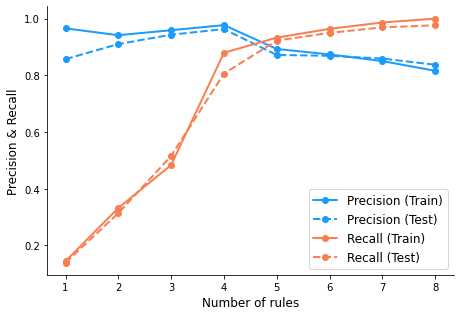

In [53]:
ax = plt.subplots()[1]
ax.plot(eval_train["precision"], **{**trp_kwds,**kwds})
ax.plot(eval_test["precision"], **{**tep_kwds,**kwds})
ax.plot(eval_train["recall"], **{**trr_kwds,**kwds})
ax.plot(eval_test["recall"], **{**ter_kwds,**kwds})
ax.set_ylabel("Precision & Recall", fontsize=12)
ax.set_xlabel("Number of rules", fontsize=12)
ax.legend(loc="best", fontsize=12)
plt.tight_layout()

See all selected rules and their subrules.

In [54]:
n_rules = 5
for n in np.arange(n_rules)+1:
    key = f"Rule_{n}"
    print(key)
    print_rule(model.rules[key])
    print()

Rule_1
Operator:  and
+------+--------------------------------+------+-------+
| Item | Variable                       | Sign | Value |
+------+--------------------------------+------+-------+
|  1   | ratio_to_median_purchase_price |  >   |  3.98 |
|  2   | online_order_no                |  <=  |  0.50 |
|  3   | distance_from_last_transaction |  <=  |  6.73 |
|  4   | ratio_to_median_purchase_price |  <=  |  5.93 |
|  5   | distance_from_home             |  >   |  8.97 |
+------+--------------------------------+------+-------+

Rule_2
Operator:  and
+------+--------------------------------+------+--------+
| Item | Variable                       | Sign |  Value |
+------+--------------------------------+------+--------+
|  1   | ratio_to_median_purchase_price |  <=  |   4.00 |
|  2   | distance_from_home             |  >   | 100.16 |
|  3   | online_order_yes               |  >   |   0.50 |
|  4   | used_chip_no                   |  >   |   0.50 |
+------+----------------------------

Use **`self.transform`** to convert rules into features array.

In [55]:
model.transform(Xt_train, n_rules).head()

,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,True,False,False
4,False,False,False,False,False


Summary on `Xt_train`

In [56]:
yt_pred_train = model.transform(Xt_train, n_rules).sum(1)>0
print_stats(yt_train, yt_pred_train)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 7,000 |       |
| Target         |   581 |  8.3% |
| True Positive  |   542 |  7.7% |
| True Negative  | 6,354 | 90.8% |
| False Positive |    65 |  0.9% |
| False Negative |    39 |  0.6% |
| Precision      |       | 89.3% |
| Recall         |       | 93.3% |
| Accuracy       |       | 98.5% |
| F1-Score       |       | 91.2% |
+----------------+-------+-------+


In [57]:
yt_pred_test = model.transform(Xt_test, n_rules).sum(1)>0
print_stats(yt_test, yt_pred_test)

+----------------+-------+-------+
| Statistics     | Value |     % |
+----------------+-------+-------+
| N              | 3,000 |       |
| Target         |   258 |  8.6% |
| True Positive  |   238 |  7.9% |
| True Negative  | 2,707 | 90.2% |
| False Positive |    35 |  1.2% |
| False Negative |    20 |  0.7% |
| Precision      |       | 87.2% |
| Recall         |       | 92.2% |
| Accuracy       |       | 98.2% |
| F1-Score       |       | 89.6% |
+----------------+-------+-------+
